# Process Stations

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pkg_resources import resource_filename

from climpyrical.gridding import transform_coords, find_element_wise_nearest_pos
from scipy.interpolate import NearestNDInterpolator

### Load station data for processing

In [3]:
# df_path = '/home/nannau/nrc_data/Interim_snow_rain_load_LR_composite_stations_delivered_v3.csv'
# df_path = '/home/nannau/nrc_data/Interim_hdd_Tmax_Tmin_delivered.csv'
# df_path = '/home/nannau/nrc_data/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
# df_path = '/home/nannau/nrc_data/sl50_from_swe50_sdmax_lrs_composite_mss.csv'
df_path = resource_filename('climpyrical', 
                            '/nrc_data/janT2.5p_T1.0p_allstations_v2_for_maps.csv')

df = pd.read_csv(df_path, index_col=None)#.dropna()
df_zero = pd.read_csv(df_path, index_col=None)


# station_dv = 'RL50 (kPa)'
# station_dv = 'SL50 (kPa)'
station_dv = 'TJan2.5 (degC)'

# station_dv = 'HDD (degC-day)'

# transform into rotated pole and assign as new columns
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        station_dv = df[station_dv] + 273.15,
        rlon=rlon_st, 
        rlat=rlat_st
)

# df_zero = df.copy()

# df = df[df[station_dv] != 0.0]
df.head(3)

/home/nannau/tri/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,history_id,station_name,province,lon,lat,elev (m),TJan2.5 (degC),TJan1.0 (degC),station_dv,rlon,rlat
0,31,DISCOVERY ISLAND,BC,-123.226,48.4246,19,0.7,-1.4,273.85,-17.091967,3.813107
1,42,ESQUIMALT HARBOUR,BC,-123.439,48.4320,3,-1.4,-3.2,271.75,-17.223366,3.866425
2,56,MALAHAT,BC,-123.530,48.5749,366,-5.2,-7.0,267.95,-17.233219,4.021213


### Open the pre-processed model

In [4]:
# dv = 'Rain-RL50'
# dv = 'heating_degree_days_per_time_period'
# dv = 'snw'
dv = 'tas'

pre_processed_path = resource_filename(
    "climpyrical", 
    "/nrc_data/processed/pre_processed.nc"
)

ds = xr.open_dataset(pre_processed_path)
ds

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    tas      (rlat, rlon) float64 ...

### Match stations to grids in model
Find the nearest grid cells to the station locations

In [42]:
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df.rlon.values, 
            df.rlat.values
)

matched_df = pd.DataFrame({'ilocy': iy, 'ilocx': ix, station_dv: df[station_dv] + 273.15, 'rlat':df.rlat, 'rlon':df.rlon, 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'rlat':'mean', 'rlon':'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})

iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
station_vals = matched_df[station_dv].values

In [43]:
# station_vals

In [44]:
print(station_vals.shape, df.shape)

(497,) (531, 11)


Identify locations where the closest grid cell falls on a invalid model value

In [45]:
nan_index = np.isnan(ds[dv].values[iy, ix])
ixnan, iynan = matched_df.ilocx.values[nan_index], matched_df.ilocy.values[nan_index]
ixnan, iynan

(array([], dtype=int64), array([], dtype=int64))

Create an interpolator that can find the nearest valid model value at these locations

In [46]:
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

model_nan = ~np.isnan(ds[dv])
model_vals = ds[dv].values[iy, ix]

f = NearestNDInterpolator(np.stack([rlon[model_nan], rlat[model_nan]]).T, ds[dv].values[model_nan])

Replace those invalid values with their nearest neighbor based on above interpolator.

In [47]:
model_vals[nan_index] = f(np.stack([rlon[iynan, ixnan], rlat[iynan, ixnan]]).T)

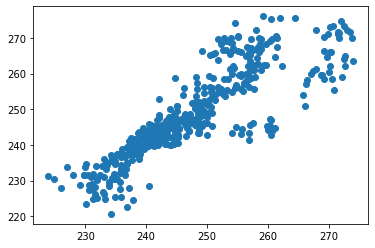

In [48]:
plt.scatter(station_vals, model_vals)

Now each station should be matched with a value grid cell value

In [49]:
ratio = matched_df[station_dv]/model_vals
assert not np.any(np.isnan(ratio))

### Normalize the model mean to match that of the station distribution
Find a factor, $\beta$ such that the model mean $$\frac{\mu_m}{\beta} \approx \mu_s$$ where $\mu_s$ is the station mean. 

0.1 <= 1.0036396586208232 < 3.010919119378096
New difference -1.1766789203470425e-05


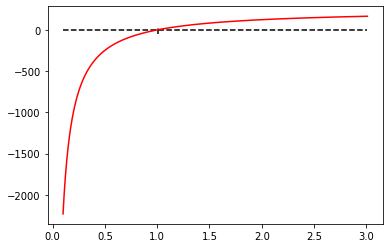

In [55]:
# choose starting value
# station_vals_no_0 = station_vals[station_vals != 0.0]
# model_vals_no_0 = model_vals[station_vals != 0.0]

start = np.nanmean(model_vals)/np. nanmean(station_vals)

# enter tolerances
tol = np.linspace(0.1, start*3, 10000)

diff = np.array([np.nanmean(station_vals - model_vals/t) for t in tol])
# idx = np.argwhere(np.diff(np.sign(np.zeros(tol.shape) - diff))).flatten()
best_tol = tol[np.where(np.diff(np.sign(diff)))[0][0]]
# best_tol = tol[idx][0]

plt.plot(tol, diff, color='red')
plt.hlines(0, tol.min(), tol.max(), color='black', linestyle='--')
plt.vlines(best_tol, -50, 50, color='black', linestyle='--')
plt.plot()

# rmtols = np.array([np.nanmean(station_vals - (model_vals/t)) for t in tol])
# print(rmtols)
# best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0][0]]

print(tol.min(), "<=", best_tol, "<", tol.max())

# apply correction
model_vals_corrected = model_vals/best_tol
mean_corrected = ds[dv].values/best_tol

# ratio = np.log(station_vals/model_vals_corrected)
ratio = station_vals/model_vals_corrected
# ratio = (station_vals-model_vals_corrected)/np.nanstd(mean_corrected)
# ratio = np.sqrt(-(station_vals-5))/np.sqrt(-(model_vals_corrected-5))


print("New difference", np.nanmean(station_vals - model_vals_corrected))

# calculate ratios with applied correction
matched_df = matched_df.assign(ratio=ratio)


In [56]:
matched_df = matched_df.assign(model_vals = model_vals, best_tol = best_tol)

In [57]:
# final_df = pd.concat([matched_df, df_zero[df_zero[station_dv] == 0.0]], sort=False)

In [58]:
# final_df.to_csv('./data/processed/processed_station.csv')
df_path_write = resource_filename('climpyrical', '/nrc_data/processed/processed_station.csv')
matched_df.to_csv(df_path_write)

matched_df

,ilocy,ilocx,TJan2.5 (degC),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,552,1011,257.35,-4.517790,10.457750,42.03330,-82.90000,HARROW CDA AUTO,0.984641,262.315497,1.00364
1,552,1017,257.15,-4.549355,10.752628,41.94860,-82.51890,POINT PELEE CS,0.966329,267.078832,1.00364
2,558,1009,256.55,-4.286849,10.373390,42.27560,-82.95560,WINDSOR A,0.997070,258.240339,1.00364
3,560,1026,258.15,-4.166610,11.147744,42.25010,-81.90010,ERIEAU (AUT),0.980031,264.368823,1.00364
4,565,1026,253.85,-3.968063,11.121350,42.45000,-81.88330,RIDGETOWN RCS,0.975062,261.290093,1.00364
...,...,...,...,...,...,...,...,...,...,...,...
492,1240,915,233.05,25.955689,6.197115,72.69330,-77.95750,POND INLET CLIMATE,1.013085,230.877232,1.00364
493,1246,562,235.15,26.214276,-9.387969,71.99250,-125.25400,SACHS HARBOUR CLIMATE,1.024517,230.358237,1.00364
494,1269,788,233.05,27.224160,0.599798,74.71635,-94.97625,RESOLUTE CARS,1.033713,226.270033,1.00364
495,1315,859,234.25,29.264606,3.758251,76.42280,-82.90220,GRISE FIORD CLIMATE,1.065369,220.677166,1.00364


In [59]:
matched_df.head()

,ilocy,ilocx,TJan2.5 (degC),rlat,rlon,lat,lon,station_name,ratio,model_vals,best_tol
0,552,1011,257.35,-4.517790,10.457750,42.0333,-82.9000,HARROW CDA AUTO,0.984641,262.315497,1.00364
1,552,1017,257.15,-4.549355,10.752628,41.9486,-82.5189,POINT PELEE CS,0.966329,267.078832,1.00364
2,558,1009,256.55,-4.286849,10.373390,42.2756,-82.9556,WINDSOR A,0.997070,258.240339,1.00364
3,560,1026,258.15,-4.166610,11.147744,42.2501,-81.9001,ERIEAU (AUT),0.980031,264.368823,1.00364
4,565,1026,253.85,-3.968063,11.121350,42.4500,-81.8833,RIDGETOWN RCS,0.975062,261.290093,1.00364


# NRC Locations

In [60]:
nrc_path = '/home/nannau/nrc_data/NBCC_2020_new_coords.xlsm'
df_nrc = pd.read_excel(nrc_path).dropna()

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# get rotated pole coordinates
rlon_st, rlat_st = transform_coords(df_nrc['2020 Longitude'].values, df_nrc['2020 Latitude'].values)
df_nrc = df_nrc.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

/home/nannau/tri/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [61]:
# find indices of the station locations
ix, iy = find_element_wise_nearest_pos(
            ds.rlon.values, 
            ds.rlat.values, 
            df_nrc.rlon.values, 
            df_nrc.rlat.values
)
# write to new dataframe
df_nrc_matched = pd.DataFrame(
    {'ilocy': iy, 
     'ilocx': ix, 
     'Location': df_nrc.Location, 
     'rlat':df_nrc.rlat, 
     'rlon':df_nrc.rlon, 
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
)

df_nrc_matched.to_csv('./data/processed/nrc_locations.csv')